In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread

%matplotlib inline

## About Convolutions

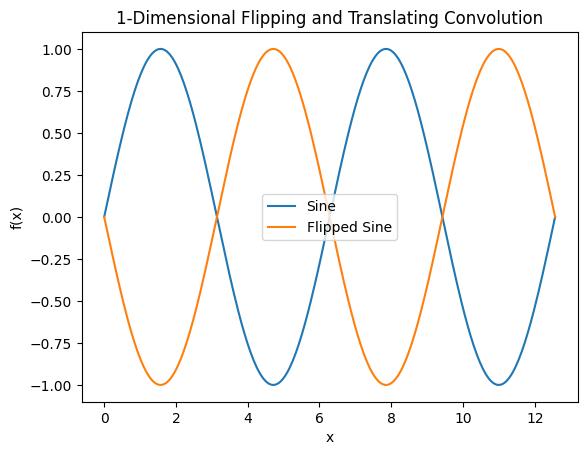

In [8]:
# Let's consider the sine function f(x) = sin(x) in the interval [0, 4 pi].
# Using a 1-dimensional convolution filter of size 5, flip vertically the sine signal and plot the result.
# Use numpy.convolve function (see the API documentation).

x = np.linspace(0, 4 * np.pi, 300)
y = np.sin(x)

fltr = [0, 0, -1, 0, 0]
y_conv = np.convolve(y, fltr, mode='same')

plt.figure()
plt.plot(x, y)
plt.plot(x, y_conv)
plt.title('1-Dimensional Flipping and Translating Convolution')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(['Sine', 'Flipped Sine'])
plt.show()

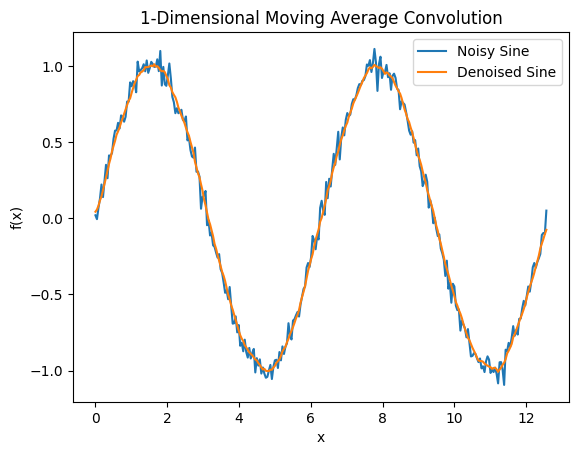

In [9]:
# Introduce a normally distributed noise (N(0, 0.05)) to the sine signal.
# Then, using a moving average convolution filter of size 10, partially remove the previously added noise and plot the result.

noise = np.random.normal(loc = 0.0, scale = 0.05, size = y.shape[0])

y_noisy = y + noise

fltr = np.repeat(1. / 10, 10)
y_conv = np.convolve(y_noisy, fltr, mode='same')

plt.figure()
plt.plot(x, y_noisy)
plt.plot(x, y_conv)
plt.title('1-Dimensional Moving Average Convolution')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(['Noisy Sine', 'Denoised Sine'])
plt.show()

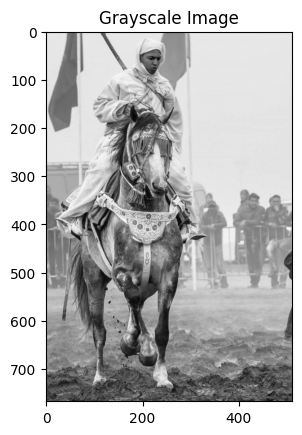

In [10]:
# Convert the given image to grayscale using the luminance formula:
# L = 0.2126 R + 0.7152 G + 0.0722 B
# where R, G, B are respectively the red, the green and the blue channel values of a pixel in the image.
# Visualize the image.

img = imread('tbourida.jpg')
img_gs = 0.2126 * img[:, :, 0] + 0.7152 * img[:, :, 1] + 0.0722 * img[:, :, 2]

plt.figure()
plt.imshow(img_gs, cmap=plt.cm.gray)
plt.title('Grayscale Image')
plt.show()

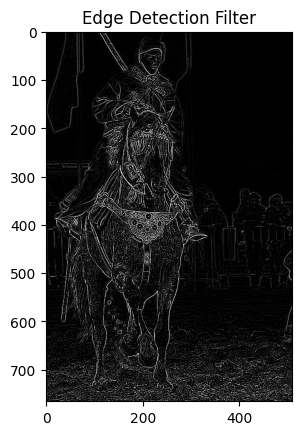

In [11]:
# Compute the 2-dimensional convolution of the image given below using the following kernel (filter):

# \begin{matrix}
# -1 & -1 & -1 \\
# -1 & 8 & -1 \\
# -1 & -1 & -1
# \end{matrx}

fltr = np.array([[-1, -1, -1], 
                   [-1,  8, -1], 
                   [-1, -1, -1]], dtype = np.float32)

img_out = np.zeros(shape=(img_gs.shape[0] - 2, img_gs.shape[1] - 2))

for i in range(img_gs.shape[0] - fltr.shape[0] + 1):
    for j in range(img_gs.shape[1] - fltr.shape[1] + 1):
        img_region = img_gs[i:i + fltr.shape[0], j:j + fltr.shape[1]]
        img_out[i, j] = np.sum(img_region * fltr)

img_out = np.where(img_out < 0, 0., img_out)
img_out = np.where(img_out > 255, 255., img_out)

plt.figure()
plt.imshow(img_out, cmap = plt.cm.gray)
plt.title('Edge Detection Filter')
plt.show()

## Computer Vision Classification Problem: CNN on CIFAR10

In [12]:
def plot_loss(history):
    """
    history: history object returned by keras fit method
    """
    plt.figure()
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Train', 'Validation'])
    plt.show()

In [15]:
# CIFAR10 is a dataset consisting of 50,000 32x32 training images and 10,000 test images, labeled over 10 categories:
# airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck.
# The images are colored (so we have 3 channels: R, G and B).

# Set the data format to 'channels_last' as follows:
# tf.keras.backend.image_data_format = 'channels_last'
# Then, load CIFAR10 data set included in tf.keras.datasets.cifar10 module, 
# scale the images and convert labels to one-hot encodings.

tf.keras.backend.image_data_format = 'channels_last'
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train = x_train / 255.
x_test = x_test / 255.

y_train_oh = tf.keras.utils.to_categorical(y_train)
y_test_oh = tf.keras.utils.to_categorical(y_test)

print(x_train.shape, y_train_oh.shape, x_test.shape, y_test_oh.shape)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


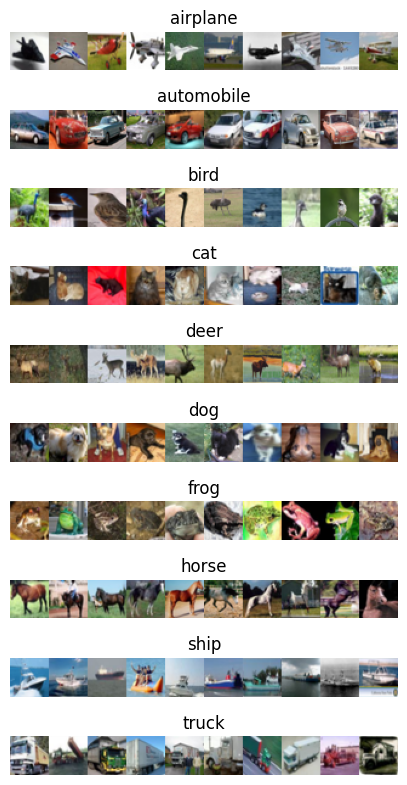

In [18]:
# Plot some images and their corresponding labels

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels = dict(zip(range(10), labels))

plt.figure(figsize = (5, 10))
for i in range(10):
    idx = np.argwhere(y_train.flatten() == i).flatten()
    idx = list(idx[:10])
    imgs = np.hstack(x_train[idx])
    plt.subplot(10, 1, i + 1)
    plt.imshow(imgs)
    plt.title(labels[i])
    plt.axis('off')
plt.show()

In [31]:
# Train a multi-layer perceptron to learn the mapping between the images and the labels.
# You have the freedom of choosing the hyperparameters.

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = x_train[0].shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation('softmax'),
])

model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.AdamW(learning_rate=0.01, weight_decay=0.05), 
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 3072)              0         
                                                                 
 dense_21 (Dense)            (None, 256)               786688    
                                                                 
 batch_normalization_14 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 activation_21 (Activation)  (None, 256)               0         
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                16448     
                                                      

In [32]:
# model training
history = model.fit(x_train, y_train_oh, epochs=30, batch_size=64, validation_split=0.15)

Epoch 1/30
665/665 [==============================] - 9s 11ms/step - loss: 1.9111 - accuracy: 0.3106 - val_loss: 1.8321 - val_accuracy: 0.3476
Epoch 2/30
665/665 [==============================] - 7s 10ms/step - loss: 1.7801 - accuracy: 0.3590 - val_loss: 1.7911 - val_accuracy: 0.3461
Epoch 3/30
665/665 [==============================] - 7s 10ms/step - loss: 1.7493 - accuracy: 0.3697 - val_loss: 1.7903 - val_accuracy: 0.3464
Epoch 4/30
665/665 [==============================] - 7s 10ms/step - loss: 1.7293 - accuracy: 0.3817 - val_loss: 1.9411 - val_accuracy: 0.3120
Epoch 5/30
665/665 [==============================] - 7s 10ms/step - loss: 1.7168 - accuracy: 0.3818 - val_loss: 1.8102 - val_accuracy: 0.3583
Epoch 6/30
665/665 [==============================] - 7s 10ms/step - loss: 1.7104 - accuracy: 0.3904 - val_loss: 1.7943 - val_accuracy: 0.3301
Epoch 7/30
665/665 [==============================] - 7s 10ms/step - loss: 1.7016 - accuracy: 0.3891 - val_loss: 1.6942 - val_accuracy: 0.3943

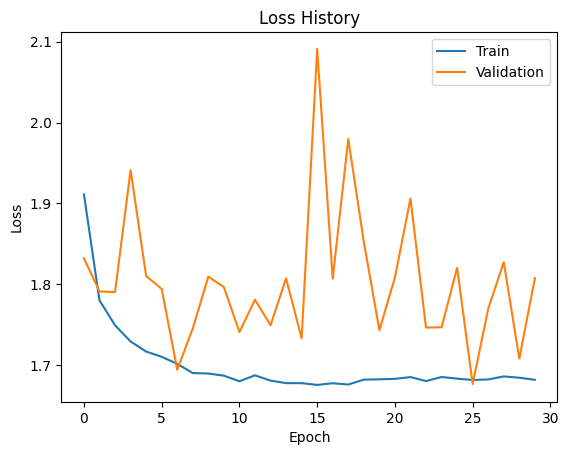

In [34]:
# Plot the training and the validation losses

plot_loss(history)

As you can see, the neural network above, which is a Multi Layer Perceptron, does not perform well. It is not adapted to images for the limitations we have seen in the lecture.

In [44]:
# As you can see, the MLP tends to overfit when solving computer vision problems. 
# Let's now implement a deep convolutional neural network (CNN) and apply it on the CIFAR10 classification task.

# Fit a CNN having the following architecture:

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=x_train[0].shape),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation('softmax')
])

model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.005), 
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 activation_40 (Activation)  (None, 30, 30, 16)        0         
                                                                 
 batch_normalization_28 (Ba  (None, 30, 30, 16)        64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 15, 15, 16)        0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 15, 15, 16)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 32)      

In [45]:
history = model.fit(x_train, y_train_oh, epochs=100, batch_size=32, validation_split=0.15)

Epoch 1/100
1329/1329 [==============================] - 24s 17ms/step - loss: 1.6386 - accuracy: 0.4111 - val_loss: 1.8029 - val_accuracy: 0.3837
Epoch 2/100
1329/1329 [==============================] - 22s 16ms/step - loss: 1.3660 - accuracy: 0.5144 - val_loss: 1.2601 - val_accuracy: 0.5597
Epoch 3/100
1329/1329 [==============================] - 22s 16ms/step - loss: 1.2714 - accuracy: 0.5482 - val_loss: 1.2511 - val_accuracy: 0.5481
Epoch 4/100
1329/1329 [==============================] - 21s 16ms/step - loss: 1.2020 - accuracy: 0.5764 - val_loss: 1.1244 - val_accuracy: 0.6104
Epoch 5/100
1329/1329 [==============================] - 21s 16ms/step - loss: 1.1570 - accuracy: 0.5899 - val_loss: 1.2326 - val_accuracy: 0.5587
Epoch 6/100
1329/1329 [==============================] - 22s 17ms/step - loss: 1.1283 - accuracy: 0.6010 - val_loss: 1.5284 - val_accuracy: 0.4739
Epoch 7/100
1329/1329 [==============================] - 20s 15ms/step - loss: 1.1059 - accuracy: 0.6117 - val_loss: 1

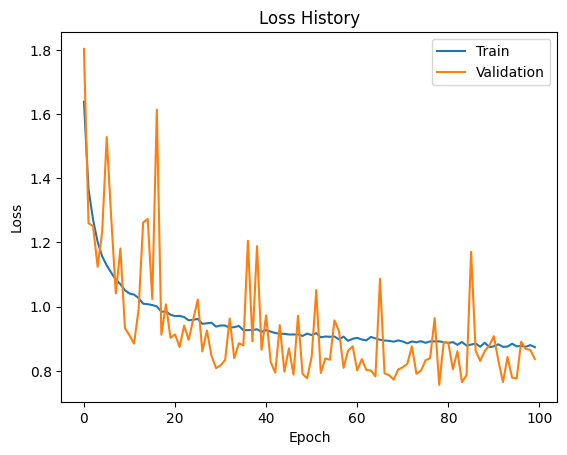

In [46]:
plot_loss(history)

In [47]:
model.evaluate(x_test, y_test_oh)

313/313 [==============================] - 2s 5ms/step - loss: 0.8511 - accuracy: 0.6987


[0.8511149287223816, 0.6987000107765198]

There is still room for improvement: The loss function plateau is not reached. Also, changing the architecture of the model (adding more layers and filters, changing hyperparameters, reducing the learning rate, etc.) would increase the performance of the model...